# Classification

# 1. Loading Library

In [115]:
import pandas as pd
import numpy as np
import time
import os
import getpass

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

In [3]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [4]:
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.cluster.hierarchy import fcluster
from sklearn.cluster import DBSCAN

In [5]:
from imblearn.over_sampling import SMOTENC

C:\ai\python\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\ai\python\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.ensemble.bagging module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\ai\python\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.ensemble.base module is  deprecated in version 0.22 and will be removed in versi

# 2. Loading Data

## 2-1. client data

In [6]:
# 고객 데이터를 불러온다.
df_client = pd.read_csv("./data/01client_demo.csv", encoding="cp949")
df_client.head()

,고객번호,성별,연령대,거주지역
0,1,M,60세이상,60.0
1,2,M,60세이상,100.0
2,3,M,60세이상,33.0
3,4,F,60세이상,16.0
4,5,M,60세이상,100.0


In [7]:
# 서울시 데이터만 선별하기 위해 우편 데이터를 가져온다.
comuser = getpass.getuser()
path = f'C:\\Users\\{comuser}\\Desktop\\ModuleProject01\data\post_num'

file_list = []
# r=root, d=directories, f = files
for r, d, f in os.walk(path):
    for file in f:
        if '.xlsx' in file:
            file_list.append(os.path.join(r, file))

In [8]:
# 파일명을 가진 변수로 데이터프레임을 생성한다.
for file in file_list :
    save_file = file.split('\\')[-1].split('.')[0]
    globals()[save_file] = pd.read_excel(file.replace('\\', '\\\\'))

In [9]:
서울시.head()

,우편번호\n(구역번호),시도,시군구,읍면,도로명주소,범위종류
0,6267,서울특별시,강남구,NaN,강남대로 238 ~ 246,짝수
1,6266,서울특별시,강남구,NaN,강남대로 248 ~ 256,짝수
2,6265,서울특별시,강남구,NaN,강남대로 262 ~ 276,짝수
3,6258,서울특별시,강남구,NaN,강남대로 278 ~ 292,짝수
4,6253,서울특별시,강남구,NaN,강남대로 298 ~ 318,짝수


In [10]:
def s_cut_postnum(df):
    df['CutPostnum'] = df['우편번호\n(구역번호)'].apply(lambda x: str(x)[0:2])

In [11]:
s_cut_postnum(서울시)
서울시.head()

,우편번호\n(구역번호),시도,시군구,읍면,도로명주소,범위종류,CutPostnum
0,6267,서울특별시,강남구,NaN,강남대로 238 ~ 246,짝수,62
1,6266,서울특별시,강남구,NaN,강남대로 248 ~ 256,짝수,62
2,6265,서울특별시,강남구,NaN,강남대로 262 ~ 276,짝수,62
3,6258,서울특별시,강남구,NaN,강남대로 278 ~ 292,짝수,62
4,6253,서울특별시,강남구,NaN,강남대로 298 ~ 318,짝수,62


In [12]:
s_postnum = 서울시['CutPostnum']
s_koo = 서울시['시군구']

frame = { '거주지역': s_postnum, 'S_koo': s_koo } 

df_post_s = pd.DataFrame(frame)
df_post_s.head()

,거주지역,S_koo
0,62,강남구
1,62,강남구
2,62,강남구
3,62,강남구
4,62,강남구


In [13]:
df_post_s['거주지역'] = df_post_s['거주지역'].apply(lambda x : np.float64(x))
df_post_s = df_post_s.drop_duplicates()
s_df_client = df_client[df_client['거주지역']<100]
s_df_client.head()

,고객번호,성별,연령대,거주지역
0,1,M,60세이상,60.0
2,3,M,60세이상,33.0
3,4,F,60세이상,16.0
6,7,F,60세이상,36.0
7,8,M,60세이상,10.0


In [14]:
s_df_client = pd.merge(s_df_client, df_post_s, how='left')
s_df_client.head()

,고객번호,성별,연령대,거주지역,S_koo
0,1,M,60세이상,60.0,강남구
1,3,M,60세이상,33.0,은평구
2,4,F,60세이상,16.0,노원구
3,7,F,60세이상,36.0,서대문구
4,8,M,60세이상,10.0,강북구


In [15]:
len(s_df_client)

5841

## 2-2. purchase data

### 해당 데이터 크기가 커서 서울시 데이터로 불러와서 분석할 것!

In [16]:
# 고객 구매내역 불러오기 ... 시간이 오래걸려서 확인
start = time.time()

df_purchase = pd.read_csv('./data/02purchaseTR.csv', encoding='CP949')

print("time :", time.time() - start)  # 현재시각 - 시작시간 = 실행 시간

time : 17.334537982940674


In [17]:
df_purchase.head()

,제휴사,영수증번호,대분류코드,중분류코드,소분류코드,고객번호,점포코드,구매일자,구매시간,구매금액
0,B,8664000,15,1504,B150401,17218,44,20140222,20,2420
1,B,8664000,16,1601,B160101,17218,44,20140222,20,1070
2,B,8664000,16,1602,B160201,17218,44,20140222,20,8060
3,B,8664000,18,1803,B180301,17218,44,20140222,20,6000
4,B,8664001,5,509,B050901,17674,44,20140222,22,1120


In [18]:
# 데이터 크기가 크기 때문에 sample 수 확인
df_purchase.shape

(28593030, 10)

In [19]:
# 서울시 고객 데이터의 구매내역만 불러온다.
s_df_purchase = pd.merge(s_df_client, df_purchase, how='left')
#s_df_purchase.drop(['성별', '연령대', '거주지역', 'S_koo'], axis='columns', inplace=True)
s_df_purchase.head()

,고객번호,성별,연령대,거주지역,S_koo,제휴사,영수증번호,대분류코드,중분류코드,소분류코드,점포코드,구매일자,구매시간,구매금액
0,1,M,60세이상,60.0,강남구,A,1239451,2,201,A020105,12,20140118,15,10000
1,1,M,60세이상,60.0,강남구,A,1319908,4,402,A040214,20,20140203,15,129000
2,1,M,60세이상,60.0,강남구,A,1807440,1,103,A010302,12,20140425,12,7000
3,1,M,60세이상,60.0,강남구,A,1807440,1,104,A010404,12,20140425,12,2650
4,1,M,60세이상,60.0,강남구,A,1807440,1,105,A010501,12,20140425,12,9800


In [20]:
s_df_purchase.shape

(8181992, 14)

In [21]:
# 구매내역 데이터 파일 크기가 크기 때문에 서울시 구매내역으로 데이터를 대체하여 새로 저장한다.
s_df_purchase.to_csv('./data/02_s_purchaseTR.csv', index=False)

In [22]:
# 서울시 고객의 구매내역 데이터 불러오기
s_df_purchase = pd.read_csv('./data/02_s_purchaseTR.csv')
s_df_purchase.head()

,고객번호,성별,연령대,거주지역,S_koo,제휴사,영수증번호,대분류코드,중분류코드,소분류코드,점포코드,구매일자,구매시간,구매금액
0,1,M,60세이상,60.0,강남구,A,1239451,2,201,A020105,12,20140118,15,10000
1,1,M,60세이상,60.0,강남구,A,1319908,4,402,A040214,20,20140203,15,129000
2,1,M,60세이상,60.0,강남구,A,1807440,1,103,A010302,12,20140425,12,7000
3,1,M,60세이상,60.0,강남구,A,1807440,1,104,A010404,12,20140425,12,2650
4,1,M,60세이상,60.0,강남구,A,1807440,1,105,A010501,12,20140425,12,9800


## 2-3. product data

In [23]:
# 상품정보 불러오기
df_product =  pd.read_csv('./data/03product.csv', encoding='CP949')
df_product.head()

,제휴사,대분류코드,중분류코드,소분류코드,중분류명,소분류명
0,A,1,101,A010101,일용잡화,위생세제
1,A,1,101,A010102,일용잡화,휴지류
2,A,1,101,A010103,일용잡화,뷰티상품
3,A,1,101,A010104,일용잡화,일용잡화
4,A,1,101,A010105,일용잡화,세트상품


## 2-4. channel data

In [24]:
# 채널정보 불러오기
df_channel = pd.read_csv("./data/06channel.csv", encoding="cp949")
df_channel.head()

,고객번호,제휴사,이용횟수
0,7,A_MOBILE/APP,4
1,14,A_MOBILE/APP,1
2,42,B_MOBILE/APP,23
3,74,A_MOBILE/APP,1
4,74,B_MOBILE/APP,30


In [25]:
df_channel.isnull().sum()

고객번호    0
제휴사     0
이용횟수    0
dtype: int64

In [26]:
# 서울시 고객의 채널 데이터 변경
s_df_channel = pd.merge(s_df_client, df_channel, how='left')
s_df_channel.head()

,고객번호,성별,연령대,거주지역,S_koo,제휴사,이용횟수
0,1,M,60세이상,60.0,강남구,NaN,NaN
1,3,M,60세이상,33.0,은평구,NaN,NaN
2,4,F,60세이상,16.0,노원구,NaN,NaN
3,7,F,60세이상,36.0,서대문구,A_MOBILE/APP,4.0
4,8,M,60세이상,10.0,강북구,NaN,NaN


# 3. EDA(Exploratory Data Analysis)

## 3-0. target

In [123]:
# 고객별 1년간 구매금액 및 구매금액구간을 구한다.
custTotal = s_df_purchase.groupby(s_df_purchase['고객번호']).sum().iloc[:,-2:]

custTotal['구매금액_1년'] = custTotal['구매금액'] // 2

bins = np.linspace(custTotal['구매금액_1년'].min(), custTotal['구매금액_1년'].max(), 20)
custTotal['구매금액구간'] = np.digitize(custTotal['구매금액_1년'], bins)

custTotal = custTotal.iloc[:,-3:]

custTotal.head()

,구매금액,구매금액_1년,구매금액구간
고객번호,,,
1,85042550,42521275,1
3,3165167,1582583,1
4,16693810,8346905,1
7,73726276,36863138,1
8,62355952,31177976,1


In [28]:
custTotal['구매금액구간'].value_counts()

1     5491
2      277
3       44
4       14
6        4
7        2
10       2
5        2
8        2
17       1
9        1
20       1
Name: 구매금액구간, dtype: int64

In [29]:
len(custTotal)

5841

(array([5.768e+03, 5.800e+01, 6.000e+00, 4.000e+00, 3.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00]),
 array([ 1. ,  2.9,  4.8,  6.7,  8.6, 10.5, 12.4, 14.3, 16.2, 18.1, 20. ]),
 <a list of 10 Patch objects>)

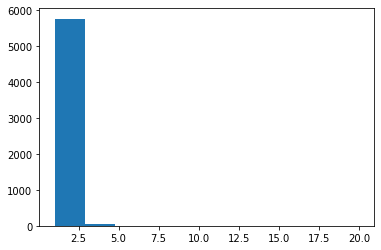

In [30]:
plt.hist(custTotal['구매금액구간'])

In [31]:
# 서울시 고객 전체에서 분포가 좌편향인 것을 확인할 수 있어서 적당한 기준을 통해 target을 설정한다.

In [124]:
custTotal['VIP'] = 0

In [125]:
# VIP 기준으로 고객을 구분짓는다(롯데백화점 400만원 + 롯데마트 600만원 + 롯데슈퍼 240만원 = 1240만원)
custTotal.loc[custTotal['구매금액_1년']>=12400000, 'VIP']=1
custTotal.loc[custTotal['구매금액_1년']<12400000, 'VIP']=0

In [34]:
custTotal.head()

,구매금액,구매금액_1년,구매금액구간,VIP
고객번호,,,,
1,85042550,42521275,1,1
3,3165167,1582583,1,0
4,16693810,8346905,1,0
7,73726276,36863138,1,1
8,62355952,31177976,1,1


In [35]:
custTotal['VIP'].value_counts()

0    3191
1    2650
Name: VIP, dtype: int64

(array([3191.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        2650.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

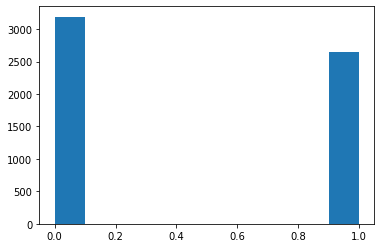

In [36]:
plt.hist(custTotal['VIP'])

## 3-1. client data

In [37]:
s_df_client.head()

,고객번호,성별,연령대,거주지역,S_koo
0,1,M,60세이상,60.0,강남구
1,3,M,60세이상,33.0,은평구
2,4,F,60세이상,16.0,노원구
3,7,F,60세이상,36.0,서대문구
4,8,M,60세이상,10.0,강북구


In [38]:
custTotal.head()

,구매금액,구매금액_1년,구매금액구간,VIP
고객번호,,,,
1,85042550,42521275,1,1
3,3165167,1582583,1,0
4,16693810,8346905,1,0
7,73726276,36863138,1,1
8,62355952,31177976,1,1


In [127]:
custTotal = custTotal.reset_index()
m_client = pd.merge(s_df_client, custTotal, how='left')
m_client.head()

,고객번호,성별,연령대,거주지역,S_koo,구매금액,구매금액_1년,구매금액구간,VIP
0,1,0,6.0,60.0,강남구,85042550,42521275,1,1
1,3,0,6.0,33.0,은평구,3165167,1582583,1,0
2,4,1,6.0,16.0,노원구,16693810,8346905,1,0
3,7,1,6.0,36.0,서대문구,73726276,36863138,1,1
4,8,0,6.0,10.0,강북구,62355952,31177976,1,1


### 성별

In [43]:
s_df_client['성별'].value_counts()

F    4854
M     987
Name: 성별, dtype: int64

In [44]:
# F(여성) = 1, M(남성) = 0
for data in enumerate(s_df_client['성별'].unique()):
    s_df_client['성별'].replace(data[1], data[0], inplace=True)

In [45]:
s_df_client['성별'].value_counts()

1    4854
0     987
Name: 성별, dtype: int64

In [47]:
cTab_sex = pd.crosstab(m_client['VIP'], m_client['성별'], margins=True)
cTab_sex

성별,F,M,All
VIP,,,
0,2641,550,3191
1,2213,437,2650
All,4854,987,5841


### 연령

In [48]:
s_df_client['연령대'].value_counts()

45세~49세    1215
40세~44세     998
50세~54세     965
35세~39세     685
55세~59세     637
60세이상       618
30세~34세     438
25세~29세     205
20세~24세      76
19세이하         4
Name: 연령대, dtype: int64

In [49]:
#60세이상 : 6.0
#55~59세 : 5.5
#50~54세 : 5.0
#45~49세 : 4.5
#40~44세 : 4.0
#35~39세 : 3.5
#30~34세 : 3.0
#25~29세 : 2.5
#20~24세 : 2.0
#19세이하 : 1.0

In [50]:
# 이 부분을 포문 돌리려다 빡쳐서 걍 ..이렇게햇어
# 숫자 는 20세~24세를 20으로 할지 2024로 할지 고민하다가 걍 일단 네자리로 하고  19세이하랑 60세 이상도
# 네자리 맞추려고 저렇게 했엉
s_df_client["연령대"] = s_df_client["연령대"].replace("19세이하", "1.0")
s_df_client["연령대"] = s_df_client["연령대"].replace("20세~24세", "2.0")
s_df_client["연령대"] = s_df_client["연령대"].replace("25세~29세", "2.5")
s_df_client["연령대"] = s_df_client["연령대"].replace("30세~34세", "3.0")
s_df_client["연령대"] = s_df_client["연령대"].replace("35세~39세", "3.5")
s_df_client["연령대"] = s_df_client["연령대"].replace("40세~44세", "4.0")
s_df_client["연령대"] = s_df_client["연령대"].replace("45세~49세", "4.5")
s_df_client["연령대"] = s_df_client["연령대"].replace("50세~54세", "5.0")
s_df_client["연령대"] = s_df_client["연령대"].replace("55세~59세", "5.5")
s_df_client["연령대"] = s_df_client["연령대"].replace("60세이상", "6.0")

s_df_client["연령대"]

0       6.0
1       6.0
2       6.0
3       6.0
4       6.0
       ... 
5836    5.0
5837    2.5
5838    2.0
5839    2.0
5840    2.0
Name: 연령대, Length: 5841, dtype: object

In [51]:
cTab_age = pd.crosstab(m_client['VIP'], m_client['연령대'], margins=True)
cTab_age

연령대,19세이하,20세~24세,25세~29세,30세~34세,35세~39세,40세~44세,45세~49세,50세~54세,55세~59세,60세이상,All
VIP,,,,,,,,,,,
0,4,65,147,270,358,553,634,523,323,314,3191
1,0,11,58,168,327,445,581,442,314,304,2650
All,4,76,205,438,685,998,1215,965,637,618,5841


In [52]:
s_df_client['연령대'].sort_values()

5714    1.0
5589    1.0
5733    1.0
5276    1.0
4998    2.0
       ... 
233     6.0
232     6.0
231     6.0
229     6.0
0       6.0
Name: 연령대, Length: 5841, dtype: object

(array([   4.,   76.,  205.,  438.,  685.,  998., 1215.,  965.,  637.,
         618.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <a list of 10 Patch objects>)

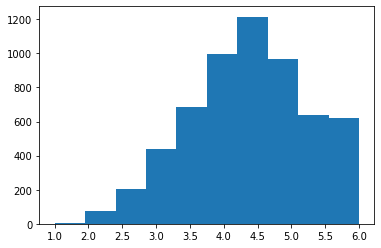

In [53]:
plt.hist(s_df_client['연령대'].sort_values())

### 거주지역

In [54]:
s_df_client['거주지역'].value_counts()

55.0    1431
16.0     819
60.0     603
24.0     339
49.0     329
47.0     278
13.0     220
10.0     185
75.0     175
27.0     146
36.0     139
39.0     119
65.0     114
72.0     109
43.0     109
33.0      96
87.0      95
69.0      94
52.0      88
20.0      76
82.0      68
30.0      66
45.0      54
79.0      48
85.0      41
Name: 거주지역, dtype: int64

In [55]:
cTab_place = pd.crosstab(m_client['VIP'], m_client['거주지역'], margins=True)
cTab_place

거주지역,10.0,13.0,16.0,20.0,24.0,27.0,30.0,33.0,36.0,39.0,...,60.0,65.0,69.0,72.0,75.0,79.0,82.0,85.0,87.0,All
VIP,,,,,,,,,,,,,,,,,,,,,
0,118,114,460,37,196,71,26,70,90,69,...,239,59,46,63,144,34,50,28,57,3191
1,67,106,359,39,143,75,40,26,49,50,...,364,55,48,46,31,14,18,13,38,2650
All,185,220,819,76,339,146,66,96,139,119,...,603,114,94,109,175,48,68,41,95,5841


(array([1224.,  415.,  308.,  258.,  441., 1848.,  603.,  208.,  332.,
         204.]),
 array([10. , 17.7, 25.4, 33.1, 40.8, 48.5, 56.2, 63.9, 71.6, 79.3, 87. ]),
 <a list of 10 Patch objects>)

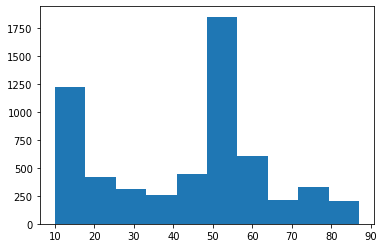

In [56]:
plt.hist(s_df_client['거주지역'])

In [57]:
m_client

,고객번호,성별,연령대,거주지역,S_koo,구매금액,구매금액_1년,구매금액구간,VIP
0,1,M,60세이상,60.0,강남구,85042550,42521275,1,1
1,3,M,60세이상,33.0,은평구,3165167,1582583,1,0
2,4,F,60세이상,16.0,노원구,16693810,8346905,1,0
3,7,F,60세이상,36.0,서대문구,73726276,36863138,1,1
4,8,M,60세이상,10.0,강북구,62355952,31177976,1,1
...,...,...,...,...,...,...,...,...,...
5836,19371,F,50세~54세,52.0,강동구,6013639,3006819,1,0
5837,19375,F,25세~29세,49.0,광진구,21486594,10743297,1,0
5838,19376,M,20세~24세,24.0,동대문구,7068554,3534277,1,0
5839,19379,F,20세~24세,69.0,동작구,5779280,2889640,1,0


In [58]:
vip_place = m_client['거주지역'][m_client['VIP'] == 1]
vip_place

0       60.0
3       36.0
4       10.0
7       43.0
8       24.0
        ... 
5815    52.0
5817    43.0
5819    39.0
5823    39.0
5830    16.0
Name: 거주지역, Length: 2650, dtype: float64

In [59]:
normal_place = m_client['거주지역'][m_client['VIP'] == 0]
normal_place

1       33.0
2       16.0
5       24.0
6       43.0
10      33.0
        ... 
5836    52.0
5837    49.0
5838    24.0
5839    69.0
5840    39.0
Name: 거주지역, Length: 3191, dtype: float64

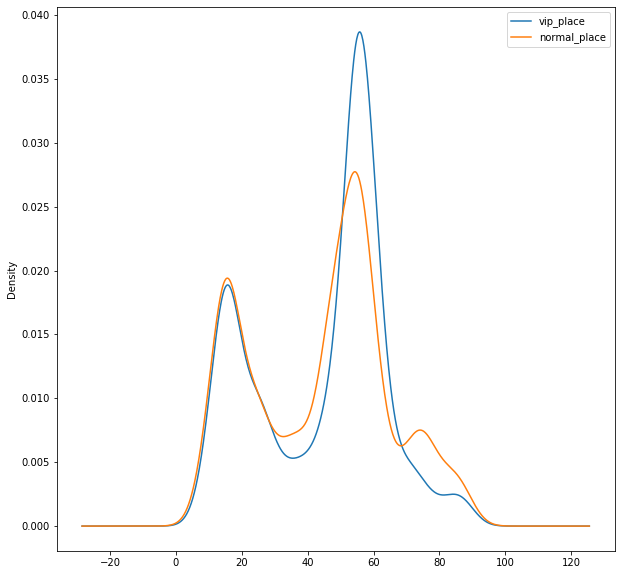

In [60]:
plt.figure(figsize =(10, 10))
vip_place.plot(kind='kde')
normal_place.plot(kind='kde')
plt.legend(['vip_place', 'normal_place'])

In [61]:
m_client.corr()["VIP"]

고객번호      -0.224066
거주지역       0.013590
구매금액       0.451925
구매금액_1년    0.451925
구매금액구간     0.183002
VIP        1.000000
Name: VIP, dtype: float64

## 3-2. purchase data

In [62]:
s_df_purchase.head()

,고객번호,성별,연령대,거주지역,S_koo,제휴사,영수증번호,대분류코드,중분류코드,소분류코드,점포코드,구매일자,구매시간,구매금액
0,1,M,60세이상,60.0,강남구,A,1239451,2,201,A020105,12,20140118,15,10000
1,1,M,60세이상,60.0,강남구,A,1319908,4,402,A040214,20,20140203,15,129000
2,1,M,60세이상,60.0,강남구,A,1807440,1,103,A010302,12,20140425,12,7000
3,1,M,60세이상,60.0,강남구,A,1807440,1,104,A010404,12,20140425,12,2650
4,1,M,60세이상,60.0,강남구,A,1807440,1,105,A010501,12,20140425,12,9800


In [128]:
custTotal.head()

,고객번호,구매금액,구매금액_1년,구매금액구간,VIP
0,1,85042550,42521275,1,1
1,3,3165167,1582583,1,0
2,4,16693810,8346905,1,0
3,7,73726276,36863138,1,1
4,8,62355952,31177976,1,1


In [129]:
custVIP = custTotal[['고객번호', '구매금액구간', 'VIP']]
m_purchase = pd.merge(s_df_purchase, custVIP, how='left')
m_purchase.head()

,고객번호,성별,연령대,거주지역,S_koo,제휴사,영수증번호,대분류코드,중분류코드,소분류코드,점포코드,구매일자,구매시간,구매금액,구매금액구간,VIP
0,1,M,60세이상,60.0,강남구,A,1239451,2,201,A020105,12,20140118,15,10000,1,1
1,1,M,60세이상,60.0,강남구,A,1319908,4,402,A040214,20,20140203,15,129000,1,1
2,1,M,60세이상,60.0,강남구,A,1807440,1,103,A010302,12,20140425,12,7000,1,1
3,1,M,60세이상,60.0,강남구,A,1807440,1,104,A010404,12,20140425,12,2650,1,1
4,1,M,60세이상,60.0,강남구,A,1807440,1,105,A010501,12,20140425,12,9800,1,1


### 제휴사

In [66]:
m_purchase['구매금액'].groupby(m_purchase['제휴사']).describe()

,count,mean,std,min,25%,50%,75%,max
제휴사,,,,,,,,
A,2275481.0,84155.929529,429816.276303,10.0,6500.0,14500.0,49000.0,93654000.0
B,3345302.0,9053.366342,129504.170345,10.0,2380.0,4280.0,7980.0,48112000.0
C,2513395.0,5210.101344,61413.931026,10.0,1490.0,2960.0,5000.0,23976000.0
D,47814.0,8428.949555,12872.029077,100.0,1600.0,3600.0,9900.0,291000.0


In [67]:
m_purchase[m_purchase['구매금액']==93654000.0]

,고객번호,성별,연령대,거주지역,S_koo,제휴사,영수증번호,대분류코드,중분류코드,소분류코드,점포코드,구매일자,구매시간,구매금액,구매금액구간,VIP
4026114,7801,M,40세~44세,69.0,동작구,A,5526155,1,109,A010901,1,20151120,13,93654000,7,1


In [68]:
m_purchase[m_purchase['구매금액']==87769260.0]

,고객번호,성별,연령대,거주지역,S_koo,제휴사,영수증번호,대분류코드,중분류코드,소분류코드,점포코드,구매일자,구매시간,구매금액,구매금액구간,VIP
5931538,13376,F,25세~29세,16.0,노원구,A,4593637,8,801,A080110,1,20150627,16,87769260,10,1


In [69]:
m_purchase[m_purchase['고객번호']==7801][m_purchase['구매금액']==120]

C:\ai\python\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,고객번호,성별,연령대,거주지역,S_koo,제휴사,영수증번호,대분류코드,중분류코드,소분류코드,점포코드,구매일자,구매시간,구매금액,구매금액구간,VIP
4026220,7801,M,40세~44세,69.0,동작구,A,2012213,1,109,A010904,1,20140525,20,120,7,1


In [70]:
m_purchase['구매금액'][m_purchase['고객번호']==7801].describe()

count    6.320000e+02
mean     1.160122e+06
std      4.546237e+06
min      1.200000e+02
25%      3.000000e+04
50%      1.995000e+05
75%      1.000000e+06
max      9.365400e+07
Name: 구매금액, dtype: float64

In [71]:
df_product[df_product['소분류코드']=='A010901']

,제휴사,대분류코드,중분류코드,소분류코드,중분류명,소분류명
120,A,1,109,A010901,주류,주류


In [72]:
df_product[df_product['소분류코드']=='A010904']

,제휴사,대분류코드,중분류코드,소분류코드,중분류명,소분류명
123,A,1,109,A010904,주류,공병


In [157]:
pd.crosstab(m_purchase['제휴사'], m_purchase['VIP'], margins=True)

VIP,0,1,All
제휴사,,,
A,614956,1660525,2275481
B,2213904,1131398,3345302
C,1932208,581187,2513395
D,41174,6640,47814
All,4802242,3379750,8181992


In [77]:
# 제휴사 A,B,C,D를 번호로 바꾸어 준다.(A->0 B->2 C->1 D->3)
for data in enumerate(m_purchase['제휴사'].unique()):
    m_purchase['제휴사'].replace(data[1], data[0], inplace=True)

In [79]:
m_purchase['제휴사'].value_counts()

2    3345302
1    2513395
0    2275481
3      47814
Name: 제휴사, dtype: int64

In [80]:
vip_compnay = m_purchase['제휴사'][m_purchase['VIP'] == 1]
normal_company = m_purchase['제휴사'][m_purchase['VIP'] == 0]

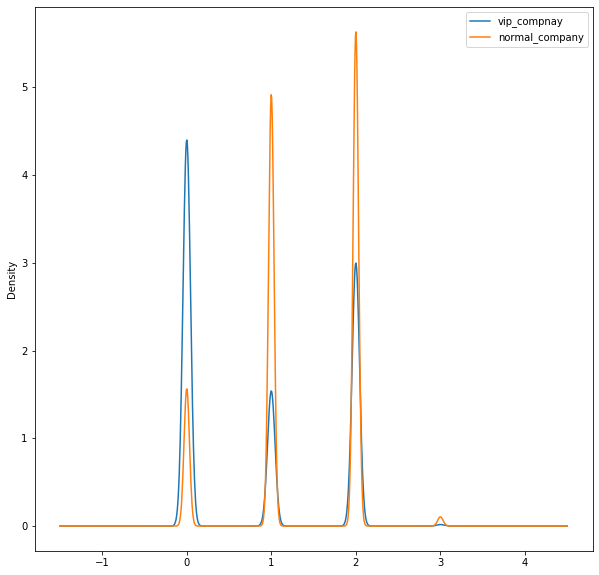

In [164]:
plt.figure(figsize =(10, 10))
vip_compnay.plot(kind='kde')
normal_company.plot(kind='kde')
plt.legend(['vip_compnay', 'normal_company'])

In [ ]:
# vip 고객 비중이 압도적으로 A 제휴사가 높은 것을 확인할 수 있다.

### 영수증번호

In [85]:
print(m_purchase['구매금액'].groupby(m_purchase['영수증번호']).mean().max())
print(m_purchase['구매금액'].groupby(m_purchase['영수증번호']).mean().min())

93654000.0
10.0


In [89]:
m_purchase.groupby(m_purchase['영수증번호']).sum().reset_index()

,영수증번호,고객번호,거주지역,제휴사,대분류코드,중분류코드,점포코드,구매일자,구매시간,구매금액,구매금액구간,VIP
0,1,2263,24.0,1,6,605,1,20140101,9,5950,1,0
1,2,2263,24.0,1,15,1502,1,20140101,12,1490,1,0
2,3,18336,24.0,1,13,1307,1,20140101,16,3980,1,0
3,4,36100,48.0,2,12,1203,2,40280202,32,10090,2,0
4,5,18104,192.0,8,58,5826,8,161120808,144,65620,8,0
...,...,...,...,...,...,...,...,...,...,...,...,...
3451378,11096588,31276,64.0,8,87,8724,540,80604052,36,57500,4,0
3451379,11096589,37700,300.0,10,218,21813,675,100755065,75,118600,5,0
3451380,11096590,30160,240.0,8,187,18712,540,80604056,68,75600,4,0
3451381,11096593,81222,330.0,12,266,26632,810,120906156,138,54000,6,0


In [90]:
# 결제당 구매총액을 구한다.
totalBill = m_purchase.groupby(m_purchase['영수증번호']).sum().reset_index()
totalBill['영수증총액'] = totalBill['구매금액']
totalBill = totalBill[['영수증번호', '영수증총액']]
totalBill.head()

,영수증번호,영수증총액
0,1,5950
1,2,1490
2,3,3980
3,4,10090
4,5,65620


In [91]:
bill_m_purchase = pd.merge(m_purchase, totalBill, how='left')
bill_m_purchase.head()

,고객번호,성별,연령대,거주지역,S_koo,제휴사,영수증번호,대분류코드,중분류코드,소분류코드,점포코드,구매일자,구매시간,구매금액,구매금액구간,VIP,영수증총액
0,1,M,60세이상,60.0,강남구,0,1239451,2,201,A020105,12,20140118,15,10000,1,1,10000
1,1,M,60세이상,60.0,강남구,0,1319908,4,402,A040214,20,20140203,15,129000,1,1,129000
2,1,M,60세이상,60.0,강남구,0,1807440,1,103,A010302,12,20140425,12,7000,1,1,58450
3,1,M,60세이상,60.0,강남구,0,1807440,1,104,A010404,12,20140425,12,2650,1,1,58450
4,1,M,60세이상,60.0,강남구,0,1807440,1,105,A010501,12,20140425,12,9800,1,1,58450


In [94]:
bill_m_purchase['영수증총액'].describe()

count    8.181992e+06
mean     5.760913e+04
std      2.569510e+05
min      1.000000e+01
25%      1.185000e+04
50%      2.696000e+04
75%      5.800000e+04
max      9.365400e+07
Name: 영수증총액, dtype: float64

In [95]:
bill_m_purchase['영수증총액'].groupby(bill_m_purchase['VIP']).describe()

,count,mean,std,min,25%,50%,75%,max
VIP,,,,,,,,
0,4802242.0,32554.234408,45185.366734,10.0,9910.0,20640.0,40860.00,7422500.0
1,3379750.0,93209.296590,393415.649288,20.0,17950.0,41580.0,87878.75,93654000.0


In [ ]:
# vip 고객의 구매건수보다 vip 아닌 고객의 구매건수가 많지만, vip고객은  평균값이 더 크고 편차가 더 크게 나타난 것을 알 수 있다.

### 분류코드

In [96]:
m_purchase['대분류코드'].value_counts()

1     1735969
3      550197
15     436565
4      394677
5      386259
       ...   
42        205
41        122
85         85
40         45
39         16
Name: 대분류코드, Length: 92, dtype: int64

In [97]:
m_purchase['중분류코드'].value_counts()

106     520069
104     340010
101     223533
402     221041
102     183020
         ...  
4003         1
5101         1
4211         1
4208         1
511          1
Name: 중분류코드, Length: 640, dtype: int64

In [98]:
m_purchase['소분류코드'].value_counts()

A010302    93145
A010401    88626
A010403    80483
A010404    73123
A010402    69855
           ...  
C170330        1
C170532        1
A060243        1
B420302        1
B330405        1
Name: 소분류코드, Length: 4137, dtype: int64

In [ ]:
# 상품의 소분류 개수는 4137개로 각각 640개의 중분류와 92개의 대분류로 나누어진다.

In [158]:
pd.crosstab(m_purchase['대분류코드'], m_purchase['VIP'], margins=True).sort_values([1], ascending=[False]).head()

VIP,0,1,All
대분류코드,,,
All,4802242,3379750,8181992
1,650117,1085852,1735969
4,147395,247282,394677
2,71826,179622,251448
3,372148,178049,550197


In [159]:
pd.crosstab(m_purchase['중분류코드'], m_purchase['VIP'], margins=True).sort_values([1], ascending=[False]).head()

VIP,0,1,All
중분류코드,,,
All,4802242,3379750,8181992
106,165936,354133,520069
104,101544,238466,340010
402,62393,158648,221041
101,126938,96595,223533


In [160]:
pd.crosstab(m_purchase['소분류코드'], m_purchase['VIP'], margins=True).sort_values([1], ascending=[False]).head()

VIP,0,1,All
소분류코드,,,
All,4802242,3379750,8181992
A010401,25287,63339,88626
A010302,32538,60607,93145
A010403,24669,55814,80483
A010404,22224,50899,73123


In [ ]:
# 대분류코드에서는 1번 항목이, 중분류에서는 106이, 소분류에서는 A010401항목의 구매 건수가 높은 것을 확인할 수 있다.

In [178]:
df_product[df_product['대분류코드']==1].head()

,제휴사,대분류코드,중분류코드,소분류코드,중분류명,소분류명
0,A,1,101,A010101,일용잡화,위생세제
1,A,1,101,A010102,일용잡화,휴지류
2,A,1,101,A010103,일용잡화,뷰티상품
3,A,1,101,A010104,일용잡화,일용잡화
4,A,1,101,A010105,일용잡화,세트상품


In [100]:
len(df_product[df_product['대분류코드']==1])

236

In [101]:
df_product['대분류코드'].value_counts()

17    306
5     288
6     240
1     236
4     232
     ... 
59      6
89      6
61      5
58      4
60      1
Name: 대분류코드, Length: 92, dtype: int64

In [180]:
df_product[df_product['중분류코드']==106].head()

,제휴사,대분류코드,중분류코드,소분류코드,중분류명,소분류명
53,A,1,106,A010601,가공식품,한식델리
54,A,1,106,A010602,가공식품,일식델리
55,A,1,106,A010603,가공식품,서양델리
56,A,1,106,A010604,가공식품,에스닉푸드
57,A,1,106,A010605,가공식품,중식델리


In [99]:
len(df_product[df_product['중분류코드']==106])

59

In [102]:
df_product['중분류코드'].value_counts()

601     114
402     105
1701     69
1706     68
602      64
       ... 
5311      1
1309      1
1409      1
5903      1
4102      1
Name: 중분류코드, Length: 656, dtype: int64

In [181]:
df_product[df_product['소분류코드']=='A010401'].head()

,제휴사,대분류코드,중분류코드,소분류코드,중분류명,소분류명
19,A,1,104,A010401,농산물,청과


In [ ]:
# 항목을 보았을 때 종합적으로 청과가 가장 구매건수가 높은 것을 확인할 수 있다.

# 대분류코드에서는 일용잡화 항목이 구매건수가 높은 것으로 나와있는데, 
# 일용잡화의 종류가 많아서 구매건수가 높게 나타난 것을 확인할 수 있다.

# 중분류코드에서는 가공식품의 항목이 구매건수가 높게 나왔는데, 
# 다른 중분류 항목과 비교하면 비교적 많지않기 때문에 구매건수가 높음을 유추할 수 있다.

### 점포코드

In [161]:
pd.crosstab(m_purchase['점포코드'], m_purchase['VIP'], margins=True).sort_values([1], ascending=[False]).head()

VIP,0,1,All
점포코드,,,
All,4802242,3379750,8181992
2,126694,493867,620561
7,328200,432055,760255
20,201342,322905,524247
12,169617,261461,431078


In [104]:
vip_store = m_purchase['점포코드'][m_purchase['VIP'] == 1]
normal_store = m_purchase['점포코드'][m_purchase['VIP'] == 0]

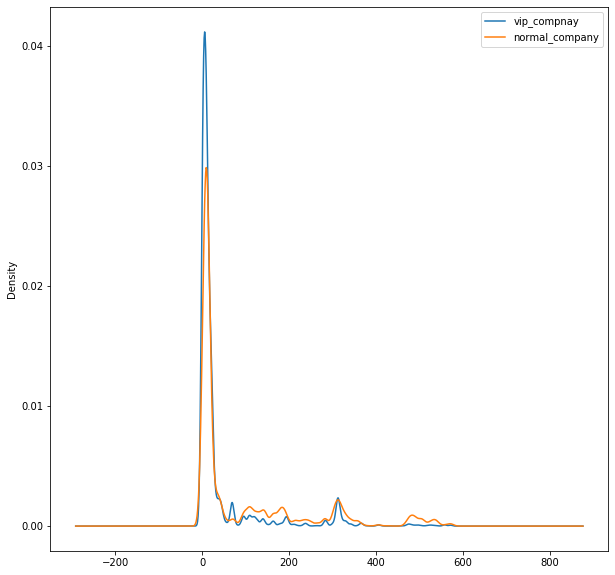

In [165]:
plt.figure(figsize =(10, 10))
vip_store.plot(kind='kde')
normal_store.plot(kind='kde')
plt.legend(['vip_compnay', 'normal_company'])

In [106]:
m_purchase['S_koo'][m_purchase['점포코드']==2].value_counts().head()

송파구    469264
강남구     45506
광진구     31431
강동구     15396
성동구     11155
Name: S_koo, dtype: int64

In [107]:
m_purchase['S_koo'][m_purchase['점포코드']==7].value_counts().head()

송파구    635914
강남구     36334
강동구     18213
광진구     15621
성동구      8106
Name: S_koo, dtype: int64

In [166]:
m_purchase['S_koo'][m_purchase['점포코드']==20].value_counts().head()

노원구    362214
도봉구     97385
강북구     11231
중랑구      9725
성북구      7383
Name: S_koo, dtype: int64

In [167]:
m_purchase['S_koo'][m_purchase['점포코드']==12].value_counts().head()

강남구    262775
강북구     87208
송파구     25805
서초구     17651
도봉구      7202
Name: S_koo, dtype: int64

In [ ]:
# VIP고객이 대체로 송파구, 강남구에 거주하는 것으로 보아 해당 지역 근처에 있는 점포에 있는 것을 확인할 수 있다.

### 구매일자

In [132]:
m_purchase['구매일자'].head()

0          20140118
1          20140203
2          20140425
3          20140425
4          20140425
             ...   
8181987    20150925
8181988    20150925
8181989    20150925
8181990    20150925
8181991    20150925
Name: 구매일자, Length: 8181992, dtype: int64

In [149]:
m_purchase['구매일자'].describe()

count                 8181992
unique                    730
top       2015-09-25 00:00:00
freq                    17696
first     2014-01-01 00:00:00
last      2015-12-31 00:00:00
Name: 구매일자, dtype: object

In [ ]:
# 2년치 데이터인 것을 알 수 있다.

In [134]:
m_purchase['구매일자'] = pd.to_datetime(m_purchase['구매일자'], format='%Y%m%d')
m_purchase['구매일자'].head()

0   2014-01-18
1   2014-02-03
2   2014-04-25
3   2014-04-25
4   2014-04-25
Name: 구매일자, dtype: datetime64[ns]

(array([363335., 369412., 398816., 389022., 416474., 409664., 405985.,
        392416., 403625., 416314., 412206., 418320., 432121., 438370.,
        442430., 454152., 424250., 392340., 393157., 409583.]),
 array([735234.  , 735270.45, 735306.9 , 735343.35, 735379.8 , 735416.25,
        735452.7 , 735489.15, 735525.6 , 735562.05, 735598.5 , 735634.95,
        735671.4 , 735707.85, 735744.3 , 735780.75, 735817.2 , 735853.65,
        735890.1 , 735926.55, 735963.  ]),
 <a list of 20 Patch objects>)

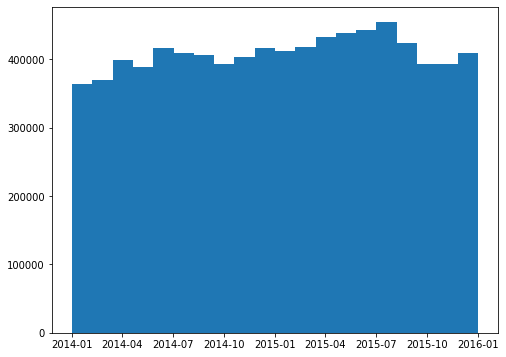

In [145]:
plt.figure(figsize=(8, 6))
plt.hist(m_purchase['구매일자'].sort_values(), bins=20)

In [168]:
pd.crosstab(m_purchase['구매일자'], m_purchase['VIP'], margins=True).sort_values([0], ascending=[False]).head()

VIP,0,1,All
구매일자,,,
All,4802242,3379750,8181992
2015-02-17 00:00:00,10479,7114,17593
2015-09-25 00:00:00,10071,7625,17696
2015-07-11 00:00:00,10013,6662,16675
2015-06-13 00:00:00,9714,5773,15487


In [162]:
pd.crosstab(m_purchase['구매일자'], m_purchase['VIP'], margins=True).sort_values([1], ascending=[False]).head()

VIP,0,1,All
구매일자,,,
All,4802242,3379750,8181992
2015-09-25 00:00:00,10071,7625,17696
2014-09-06 00:00:00,9682,7210,16892
2015-02-17 00:00:00,10479,7114,17593
2015-07-11 00:00:00,10013,6662,16675


### 구매시간

In [150]:
m_purchase['구매시간'].value_counts().head()

18    886515
17    875135
16    810246
19    779266
15    728724
Name: 구매시간, dtype: int64

(array([1.515000e+03, 1.150000e+02, 1.190000e+02, 2.695800e+04,
        6.436770e+05, 1.098510e+06, 2.190259e+06, 1.761650e+06,
        1.364804e+06, 1.094385e+06]),
 array([ 0. ,  2.3,  4.6,  6.9,  9.2, 11.5, 13.8, 16.1, 18.4, 20.7, 23. ]),
 <a list of 10 Patch objects>)

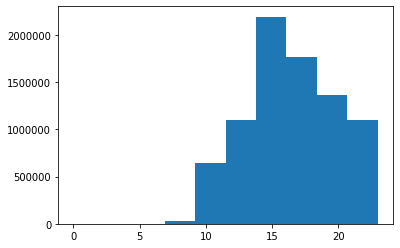

In [151]:
plt.hist(m_purchase['구매시간'])

In [156]:
pd.crosstab(m_purchase['구매시간'], m_purchase['VIP']).sort_values([0], ascending=[False]).head()

VIP,0,1
구매시간,,
18,534943,351572
17,499038,376097
19,464593,314673
16,428006,382240
20,390552,194986


In [ ]:
# VIP가 아닌 고객은 16시부터 20시에 이용이 몰려있으며, 18시에 가장 많은 고객이 이용한 것을 알 수 있다.

In [163]:
pd.crosstab(m_purchase['구매시간'], m_purchase['VIP'], margins=True).sort_values([1], ascending=[False]).head()

VIP,0,1,All
구매시간,,,
All,4802242,3379750,8181992
16,428006,382240,810246
17,499038,376097,875135
15,363692,365032,728724
18,534943,351572,886515


In [ ]:
# VIP 고객은 14시부터 18시까지 이용이 몰려있으며, 16시에 가장 많은 고객이 이용한 것을 확인할 수 있다.

In [175]:
vip_time = m_purchase['구매시간'][m_purchase['VIP'] == 1]
normal_time = m_purchase['구매시간'][m_purchase['VIP'] == 0]

KeyboardInterrupt: 

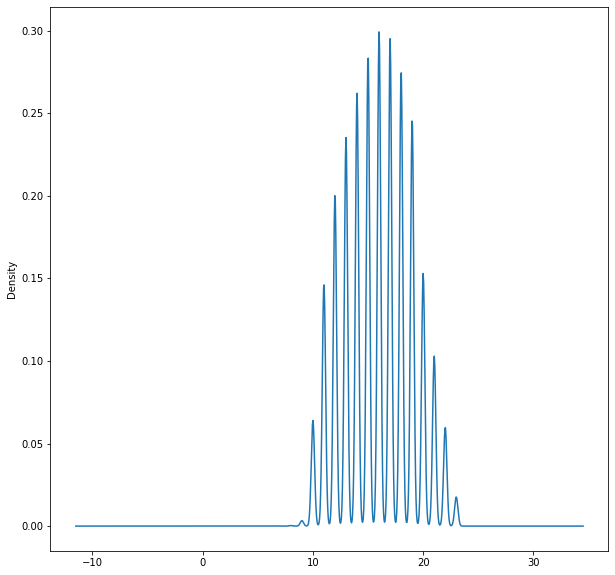

In [176]:
plt.figure(figsize =(10, 10))
vip_time.plot(kind='kde')
normal_time.plot(kind='kde')
plt.legend(['vip_compnay', 'normal_company'])

In [ ]:
# 여러가지 데이터를 보고 인터넷을 통해 알 수 있는 사실은
# A(롯데백화점), B(롯데마트), C(롯데슈퍼), D(LOHBs)
# 근거 : 영수증 별 가격 분포 / 점포수 / 취급물품

## 3-3. product data

In [ ]:
df_product.head()

In [ ]:
frame = { '제휴사': df_product['제휴사'], '중분류명': df_product['중분류명'], '소분류명':df_product['소분류명'] } 

df_product_name = pd.DataFrame(frame)

In [ ]:
df_product_name.groupby(df_product_name['제휴사']).describe()

## 3-4. channel data

In [0]:
s_df_channel[s_df_channel['고객번호'].duplicated()]

In [0]:
df_channel.shape

In [0]:
s_df_channel.isnull().sum()

In [0]:
# 전체 데이터 8824개 중 4042의 서울시 고객만이 모바일이나 웹페이지를 이용하지 않은 것을 확인할 수 있다.
# 총 5841명 중 대다수가 이용하지 않는다는 사실을 알 수 있다.

# Delete Null

In [30]:
s_df_channel

,고객번호,성별,연령대,거주지역,S_koo,제휴사,이용횟수
0,1,M,60세이상,60.0,강남구,NaN,NaN
1,3,M,60세이상,33.0,은평구,NaN,NaN
2,4,F,60세이상,16.0,노원구,NaN,NaN
3,7,F,60세이상,36.0,서대문구,A_MOBILE/APP,4.0
4,8,M,60세이상,10.0,강북구,NaN,NaN
...,...,...,...,...,...,...,...
6485,19371,F,50세~54세,52.0,강동구,NaN,NaN
6486,19375,F,25세~29세,49.0,광진구,NaN,NaN
6487,19376,M,20세~24세,24.0,동대문구,B_MOBILE/APP,1.0
6488,19379,F,20세~24세,69.0,동작구,NaN,NaN


In [31]:
cust_num =s_df_channel['고객번호']
null_partner = s_df_channel['제휴사']
null_used = s_df_channel['이용횟수']

frame = { '고객번호': cust_num, '제휴사': null_partner, '이용횟수': null_used } 

null_channel = pd.DataFrame(frame)
null_channel

,고객번호,제휴사,이용횟수
0,1,NaN,NaN
1,3,NaN,NaN
2,4,NaN,NaN
3,7,A_MOBILE/APP,4.0
4,8,NaN,NaN
...,...,...,...
6485,19371,NaN,NaN
6486,19375,NaN,NaN
6487,19376,B_MOBILE/APP,1.0
6488,19379,NaN,NaN


In [32]:
null_channel['제휴사'].fillna(0, inplace=True)
null_channel['이용횟수'].fillna(0, inplace=True)
null_channel

,고객번호,제휴사,이용횟수
0,1,0,0.0
1,3,0,0.0
2,4,0,0.0
3,7,A_MOBILE/APP,4.0
4,8,0,0.0
...,...,...,...
6485,19371,0,0.0
6486,19375,0,0.0
6487,19376,B_MOBILE/APP,1.0
6488,19379,0,0.0


In [33]:
null_channel['제휴사'].value_counts()

0               4042
B_MOBILE/APP    1295
A_MOBILE/APP     491
B_ONLINEMALL     395
C_ONLINEMALL     157
D_MOBILE/APP     101
C_MOBILE/APP       9
Name: 제휴사, dtype: int64

In [34]:
type(null_channel['제휴사'][0])

int

# 4. Data Preprocessing

# 4-1. Clustering
* 고객의 구매 내역 데이터에서 (구매빈도, 구매시간, 구매금액) 기준으로 clustering 진행
* KMeans, 계층적군집분석, DBSCAN 시도
* KMeans cluster 데이터 분포가 적절하여 해당 방식 이용

In [35]:
# 구매빈도
df_stuff_cnt = df_purchase['소분류코드'].groupby(df_purchase['소분류코드']).count()
# 구매시간
df_stuff_time = df_purchase['구매시간'].groupby(df_purchase['소분류코드']).mean()
# 구매금액
df_stuff_amt = df_purchase['구매금액'].groupby(df_purchase['소분류코드']).mean()

frame1 = { '구매빈도': df_stuff_cnt, '구매시간': df_stuff_time, '구매금액':df_stuff_amt } 

df_stuff = pd.DataFrame(frame1)
df_stuff.head()

,구매빈도,구매시간,구매금액
소분류코드,,,
A010101,101454,15.540748,11597.932166
A010102,720,15.752778,4777.805556
A010103,46517,15.547434,30730.050949
A010104,25080,15.496252,6138.696970
A010105,484,15.254132,220207.851240


### KMeans

In [36]:
feature = df_stuff[ ['구매빈도', '구매시간', '구매금액']]

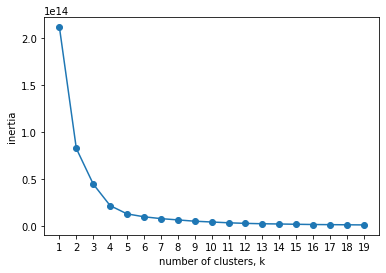

In [37]:
# 적절한 cluster 수 확인 (but 편차때문에 강제로 늘려버림 5 -> 10개)
ks = range(1,20)
inertias = []

for k in ks:
    model = KMeans(n_clusters=k)
    model.fit(feature)
    inertias.append(model.inertia_)

# Plot ks vs inertias
plt.plot(ks, inertias, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

In [38]:
# 정규표준화, KMeans, 파이프라인 선언
scaler = StandardScaler()
model = KMeans(n_clusters=10)
pipeline = make_pipeline(scaler,model)

In [39]:
# 파이프라인을 이용하여 정규표준화 한 뒤 KMeans 학습
pipeline.fit(feature)
predict = pd.DataFrame(pipeline.predict(feature))
predict.columns=['predict']

In [40]:
# clustring 결과의 분포가 적절히 이루어진 것을 확인할 수 있다.
predict['predict'].value_counts()

1    1839
9    1266
0     657
4     264
5     127
6     125
2      47
8      34
3      22
7       5
Name: predict, dtype: int64

In [41]:
# clustring 데이터와 결과값 데이터를 합침
predict = predict.set_index(feature.index)
r = pd.concat([feature,predict],axis=1)
r.head()

,구매빈도,구매시간,구매금액,predict
소분류코드,,,,
A010101,101454,15.540748,11597.932166,2
A010102,720,15.752778,4777.805556,0
A010103,46517,15.547434,30730.050949,4
A010104,25080,15.496252,6138.696970,0
A010105,484,15.254132,220207.851240,0


In [42]:
# KMeans 결과값 저장
r.to_csv('./data/r_KMeans.csv')

# 4-2. 

In [43]:
product_code = df_purchase['소분류코드']
customer_no = df_purchase['고객번호']

frame2 = { '소분류코드': product_code, '고객번호': customer_no} 

pur_product = pd.DataFrame(frame2)
pur_product.head()

,소분류코드,고객번호
0,B150401,17218
1,B160101,17218
2,B160201,17218
3,B180301,17218
4,B050901,17674


In [44]:
# 구매데이터의 소분류코드, 고객번호와 제품데이터의 clustring 결과값을 merge
pur_prod = pd.merge(pur_product, r['predict'].reset_index(), how='left')
pur_prod.head()

,소분류코드,고객번호,predict
0,B150401,17218,4
1,B160101,17218,4
2,B160201,17218,2
3,B180301,17218,1
4,B050901,17674,4


In [45]:
# cluster에 대한 가변수 생성
cluster_dumm = pd.get_dummies(pur_prod['predict'], prefix='cluster')
cluster_dumm.head()

,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9
0,0,0,0,0,1,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0


In [46]:
purchase_product = pd.concat([pur_prod,cluster_dumm],axis=1)
purchase_product = pd.concat([purchase_product['고객번호'], purchase_product.iloc[:,3:]], axis=1)
purchase_product.head()

,고객번호,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9
0,17218,0,0,0,0,1,0,0,0,0,0
1,17218,0,0,0,0,1,0,0,0,0,0
2,17218,0,0,1,0,0,0,0,0,0,0
3,17218,0,1,0,0,0,0,0,0,0,0
4,17674,0,0,0,0,1,0,0,0,0,0


In [47]:
# 고객별 제품cluster 구매 횟수
customer_product_cluster = purchase_product.groupby(purchase_product['고객번호']).sum()
customer_product_cluster.head()

,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9
고객번호,,,,,,,,,,
1,256.0,40.0,351.0,5.0,341.0,0.0,44.0,0.0,0.0,20.0
2,294.0,28.0,553.0,4.0,186.0,0.0,41.0,0.0,0.0,10.0
3,3.0,174.0,729.0,0.0,232.0,0.0,0.0,0.0,0.0,53.0
4,211.0,127.0,252.0,0.0,286.0,0.0,13.0,0.0,0.0,41.0
5,130.0,4.0,464.0,0.0,112.0,0.0,3.0,0.0,0.0,6.0


In [48]:
# 고객별 제품cluster csv파일로 저장
customer_product_cluster.to_csv('./data/cust_KMeans.csv')